# Imports and Inputs

In [1]:
### Imports of relevant python packages and Dune API Key

import pandas as pd
import requests
import matplotlib.pyplot as plt
# import seaborn as sns
from datetime import datetime, timedelta, timezone

from dune_client.client import DuneClient
from config import key

# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

/tmp/ipykernel_691/2707571157.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Links to dune queries to refresh before importing latest result in cell below:

[Capital Pool in ETH](https://dune.com/queries/3773645/6345766?display_currency_e15077=ETH)

[RAMM Volumes](https://dune.com/queries/3219988/5394288)

[Full List Of Covers V2](https://dune.com/queries/3810247)

In [2]:
# import jsons of capital pool, ramm volume and covers from dune api 
dune = DuneClient(key)
cap_pool_result = dune.get_latest_result_dataframe(3773645) # ensure that the ETH values are latest to be run
ramm_volume_result = dune.get_latest_result_dataframe(3219988)
covers_list_result = dune.get_latest_result_dataframe(3810247)

# Investment Newsletter Data

The following steps and the reasons for them were taken for the July metrics:
1. Update the valuation date string (standard each month)

In [3]:
# manually input the valuation date as a string in the format 'dd-mm-yyyy'
# the valuation date is the final day of the month for which the results are being produced
valn_date_str = '31-07-2024'

# average days in month
avg_days_in_month = 30.436875

**Kiln reward calculation**

The Kiln rewards are not currently picked up by the Enzyme chainlink oracle and so the metrics are calculated manually in this notebook.

Currently the monthly rewards are estimated by inputting the known unclaimed reward amount as at the date of updating the notebook and assuming that the rewards are evenly spread through the days since the last withdrawal.

Kiln Rewards - [AB Safe Enzyme App](https://app.safe.global/apps/open?safe=eth:0x51ad1265C8702c9e96Ea61Fe4088C2e22eD4418e&appUrl=https%3A%2F%2Fapp.enzyme.finance)

Click Vaults (left sidebar) -> Nexus Mutual Treasury Yield -> 'Portfolio' tab -> Click into Kiln Staking Positions. The relevant value is under 'Total Accrued Rewards'

Steps taken to update notebook:

2. The Enzyme idle portion was not updated, as the uninvested amount did not change in July. Note that new investments were made from the Enzyme vault in August, where the idle portion was allocated between weETH and the Stakewise/Chorus One position. The rewards from these will need to be allowed for in August.
3. The Enzyme_monthly_change amount was removed. There were no additional deposits into the vault in July, unlike June.
4. The kiln_current_rewards were updated for the Total Accrued Rewards value read from the instructions above.
5. The kiln_first_round rewards represent the amount of rewards earned in the Kiln position before the initial withdrawal of staking rewards between 2024-04-24 and 2024-04-26. This amount, and the kiln_claim_start_date and kiln_claim_end_date will remain unchanged.
6. The kiln_deposit_date represents the first deposit into Kiln and will be unchanged.

In [4]:
# manually input idle Enzyme Portion
Enzyme_idle_portion = 6575.67

# manually input kiln rewards

# fixed amount representing rewards claimed in April '24 and staked afresh in Kiln
kiln_first_round = 181.45

# TO UPDATE - current rewards pulled in from Enzyme UI
kiln_current = 72.5377

# FIXED
# create datetime object of 2023/08/30 when the Kiln validators were activated 
# kiln_deposit_date = datetime(year=2023, month=8, day=30, tzinfo=timezone.utc)
kiln_deposit_date = datetime(year=2023, month=8, day=30)
# create datetime objects of 2024/04/24 and 2024/04/26 when the Kiln rewards were first claimed.
    # Note that the values for 2024/04/25 will be inaccurate
# kiln_claim_start_date = datetime(year=2024, month=4, day=24, tzinfo=timezone.utc)
# kiln_claim_end_date = datetime(year=2024, month=4, day=26, tzinfo=timezone.utc)
kiln_claim_start_date = datetime(year=2024, month=4, day=24)
kiln_claim_end_date = datetime(year=2024, month=4, day=26)

kiln_total_rewards = kiln_first_round + kiln_current

**Aave USDC Debt Repayments**

The below cell takes in the manual inputs related to any USDC debt repayments in the month, to allow for accurately working out the interest on the debt.

The relevant values can be found by looking at the historic transactions in the [AB Multisig](https://app.safe.global/transactions/history?safe=eth:0x51ad1265C8702c9e96Ea61Fe4088C2e22eD4418e).
* If there is one payment in the valuation month, simply update the information below.
* If there are no repayments, comment out the section below and update the calculations in section 2.4.
* If there is more than one repayment, then an update to the relevant calculations below and in section 2.4. to include additional payments will be required.

Steps taken to update notebook:

7. Updated the debtUSDC_monthly_repayment as per the relevant July [transaction](https://etherscan.io/tx/0x181d37cd7a8fcfe5c899142e2d1b0e73b81fd84f639f1c353222fc5dc4da74f0). Note that the USDC amount is used.
8. Updated the repayment_date_str to match the day the repayment was made in July '24

In [5]:
# manually input debtUSDC repayment size and date of repayment

# TO UPDATE from any repayment tx's in month
debtUSDC_monthly_repayment = 242_991.668605
repayment_date_str = '02-07-2024'

# FIXED
debtUSDC_repayment_date = datetime.strptime(repayment_date_str, '%d-%m-%Y')

In [6]:
# create valuation datetime

# valn_date = datetime.strptime(valn_date_str, '%d-%m-%Y').replace(tzinfo=timezone.utc) - timezone UTC if required
valn_date = datetime.strptime(valn_date_str, '%d-%m-%Y')

# create datetime for the final day in month before valuation month

# eom_before_valn_date = datetime(year=valn_date.year, month=valn_date.month, day=1, tzinfo=timezone.utc) - timedelta(days=1) - timezone UTC if required
eom_before_valn_date = datetime(year=valn_date.year, month=valn_date.month, day=1) - timedelta(days=1)

Commented out the coingecko ETH-USD API as it is not used downstream since updating the Dune queries.

In [7]:
# # coingecko ETH API for ETH-USD at valuation date
# url = 'https://api.coingecko.com/api/v3/coins/ethereum/history'
# eth_price_params_valn = {'date': valn_date_str}
# eth_usd_valn = requests.get(url, params=eth_price_params_valn).json()['market_data']['current_price']['usd']

## Processing Capital Pool Table

In [8]:
cap_pool_result

,block_date,avg_eth_usd_price,capital_pool_display_curr,eth_display_curr,dai_display_curr,nxmty_display_curr,steth_display_curr,reth_display_curr,usdc_display_curr,cover_re_usdc_display_curr,aave_collateral_weth_display_curr,aave_debt_usdc_display_curr
0,2024-08-28 00:00:00.000 UTC,2459.633676,82074.661647,11932.034443,250.012988,13364.667090,29481.631248,14912.640009,191.676722,4881.237277,9389.971047,-2329.209176
1,2024-08-27 00:00:00.000 UTC,2624.148681,81889.196546,11939.049229,234.312376,13364.667090,29481.631248,14907.739934,179.670879,4575.496619,9389.858782,-2183.229612
2,2024-08-26 00:00:00.000 UTC,2727.080104,81881.127923,12051.625548,225.474372,13364.418989,29479.383185,14896.049403,172.833457,4402.123456,9389.380088,-2100.160575
3,2024-08-25 00:00:00.000 UTC,2765.225937,81916.235196,12133.917858,222.352282,13363.819727,29477.178704,14890.457486,169.336815,4340.845611,9388.921578,-2070.594866
4,2024-08-24 00:00:00.000 UTC,2768.332083,81991.722879,12215.603906,222.128109,13363.269085,29474.987074,14890.567037,169.113148,4335.112042,9388.468733,-2067.526254
...,...,...,...,...,...,...,...,...,...,...,...,...
1920,2019-05-27 00:00:00.000 UTC,268.692708,23.625751,23.625751,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
1921,2019-05-26 00:00:00.000 UTC,252.561806,23.629793,23.629793,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
1922,2019-05-25 00:00:00.000 UTC,251.959896,22.633834,22.633834,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
1923,2019-05-24 00:00:00.000 UTC,249.477361,21.537876,21.537876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000


In [9]:
# process capital pool table

df_cap_raw = cap_pool_result

# drop moving average columns
df_cap = df_cap_raw.drop(columns=['capital_pool_display_curr'])
# rename columns
df_cap.rename(columns={'eth_display_curr': 'ETH',
                       'dai_display_curr': 'DAI',
                       'reth_display_curr': 'rETH',
                       'steth_display_curr': 'stETH',
                       'nxmty_display_curr': 'Enzyme',
                       'usdc_display_curr': 'USDC',
                       'cover_re_usdc_display_curr': 'Cover Re',
                       'aave_collateral_weth_display_curr': 'aEthWETH',
                       'aave_debt_usdc_display_curr': 'variableDebtEthUSDC',
                       'avg_eth_usd_price': 'rate_ETH_USD',
                       'block_date': 'day'
                  }, inplace=True)


# change day to a datetime, and remove timezone
df_cap['day'] = pd.to_datetime(df_cap['day']).dt.tz_localize(None)

# Adjust Enzyme for unclaimed Kiln returns
    # work out days since kiln deposit from the latest day and work out the rewards per day
days_first_kiln_rewards = (kiln_claim_start_date - kiln_deposit_date)/timedelta(days=1)
daily_first_kiln_rewards = kiln_first_round/days_first_kiln_rewards

days_current_kiln_rewards = (df_cap.iloc[0]['day'] - kiln_claim_end_date)/timedelta(days=1)
daily_current_kiln_rewards = kiln_current/days_current_kiln_rewards

days_total_kiln_rewards = (df_cap.iloc[0]['day'] - kiln_deposit_date)/timedelta(days=1)
daily_total_kiln_rewards = kiln_total_rewards / days_total_kiln_rewards

    # create a column for kiln rewards based on the daily values since validators went live
df_cap['kiln_rewards'] = 0
df_cap.loc[df_cap['day'] <= kiln_claim_start_date, 'kiln_rewards'] = daily_first_kiln_rewards * ((df_cap['day'] - kiln_deposit_date) / timedelta(days=1))
df_cap.loc[df_cap['day'] >= kiln_claim_end_date, 'kiln_rewards'] = daily_current_kiln_rewards * ((df_cap['day'] - kiln_claim_end_date) / timedelta(days=1))
df_cap.loc[df_cap['kiln_rewards'] < 0, 'kiln_rewards'] = 0

    # Add Kiln rewards to Enzyme column and then drop the Kiln rewards column
df_cap['Enzyme'] = df_cap['Enzyme'] + df_cap['kiln_rewards']
df_cap.drop(columns=['kiln_rewards'], inplace=True)

# add all the columns except day and the exchange rate together to get numeric total
df_cap['sum'] = df_cap.drop(columns=['day', 'rate_ETH_USD']).sum(axis=1)

# work out net aave position
df_cap['Aave (net)'] = df_cap['aEthWETH'] + df_cap['variableDebtEthUSDC']

/tmp/ipykernel_691/3482859299.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  181.45         180.68760504   179.92521008 ... -1187.81134454
 -1188.5737395  -1189.33613445]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_cap.loc[df_cap['day'] <= kiln_claim_start_date, 'kiln_rewards'] = daily_first_kiln_rewards * ((df_cap['day'] - kiln_deposit_date) / timedelta(days=1))


In [10]:
df_cap.loc[(df_cap['day'] <= valn_date) & (df_cap['day'] >= eom_before_valn_date)]

,day,rate_ETH_USD,ETH,DAI,Enzyme,stETH,rETH,USDC,Cover Re,aEthWETH,variableDebtEthUSDC,sum,Aave (net)
28,2024-07-31,3294.723889,10088.430440,265.647244,13412.351744,33797.130644,14940.849537,88.406994,3644.911502,9376.283703,-1814.404930,83799.606879,7561.878773
29,2024-07-30,3314.470521,10097.995470,263.990272,13411.819835,33794.360984,14934.326317,87.879470,3623.162309,9375.774759,-1803.247196,83786.062223,7572.527564
30,2024-07-29,3338.016597,10102.460643,262.120590,13411.287920,33791.665278,14941.332128,87.198791,3595.098749,9375.256442,-1788.958169,83777.462370,7586.298272
31,2024-07-28,3254.711215,10119.162008,268.852144,13410.756009,33789.064763,14950.382520,73.604658,3689.114793,9374.737096,-1835.422303,83840.251689,7539.314793
32,2024-07-27,3271.976701,10149.045645,267.350750,13410.224105,33786.268033,14954.406398,73.201482,3668.907339,9374.215126,-1825.052411,83858.566466,7549.162715
33,2024-07-26,3249.729063,10162.475635,269.326295,13409.692198,33783.666787,14946.891879,73.711209,3694.455182,9373.694528,-1837.449751,83876.463962,7536.244777
34,2024-07-25,3175.670312,10163.703026,275.588677,13409.160279,33780.953616,14962.510270,71.033544,3781.248034,9373.165934,-1880.300375,83937.063005,7492.865558
35,2024-07-24,3428.500347,10169.084969,255.090635,13408.628383,33778.182955,14954.485192,65.757058,3501.523125,9372.469404,-1740.880106,83764.341615,7631.589297
36,2024-07-23,3473.101007,10438.761415,251.877939,13408.096473,33775.453178,14935.137775,64.899737,3455.871286,9371.942731,-1717.783692,83984.256841,7654.159039
37,2024-07-22,3488.918125,10454.387240,250.738478,13407.564556,33772.683826,14946.503915,63.451848,3440.361724,9371.452465,-1709.678618,83997.465432,7661.773846


## Pie Chart of Assets at Valuation Date

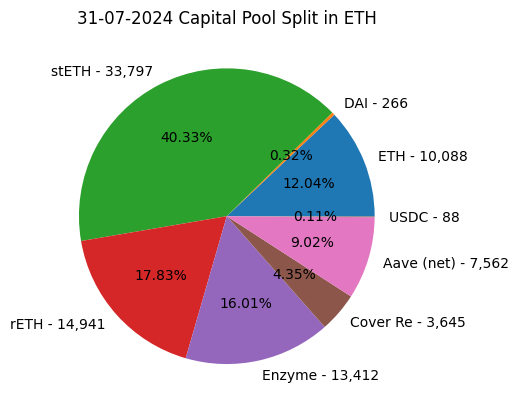

In [11]:
# pie chart of assets
asset_list = ['ETH', 'DAI', 'stETH', 'rETH', 'Enzyme', 'Cover Re', 'Aave (net)', 'USDC']
valn_date_row = df_cap.loc[df_cap['day'] == valn_date][asset_list]

# add formatted ETH values to labels
labels = []
for n, i in enumerate(asset_list):
    formatted_value = '{:,.0f}'.format(valn_date_row.values[0][n])
    labels.append(f'{i} - {formatted_value}')

# create chart
plt.pie(valn_date_row.values[0], labels=labels, autopct='%1.2f%%')
plt.title(f'{valn_date_str} Capital Pool Split in ETH');

## Monthly Changes in Capital Pool

### RAMM Net Withdrawals

In [12]:
# RAMM Net Withdrawals
df_ramm = ramm_volume_result

# change timestamp to datetime format and normalise all dates to midnight
df_ramm['ts'] = pd.to_datetime(df_ramm['ts']).dt.floor('D')

# group by date, take the latest value and re-sort into descending order
df_ramm = df_ramm.groupby(by=df_ramm['ts'].dt.date, as_index=False).first().\
            sort_values(['ts'], ascending=False).reset_index(drop=True)

# determine net ramm flows 30 days before and on the valuation date by subtracting redemptions from mints
ramm_flows_monthly_opening = df_ramm.loc[df_ramm['ts'] == eom_before_valn_date]['cummulative_eth_in'].values[0] - df_ramm.loc[df_ramm['ts'] == eom_before_valn_date]['cummulative_eth_out'].values[0]
ramm_flows_monthly_closing = df_ramm.loc[df_ramm['ts'] == valn_date]['cummulative_eth_in'].values[0] - df_ramm.loc[df_ramm['ts'] == valn_date]['cummulative_eth_out'].values[0]

# determine net flows from ramm in 30 days before valuation date 
ramm_flow_monthly_change = ramm_flows_monthly_closing - ramm_flows_monthly_opening
ramm_flow_monthly_change

-1794.9111553612966

### Cover Fees

In [13]:
df_covers = covers_list_result

# input commission ratio to obtain cover fees net of commission (representing inflows to Cap Pool)
net_of_commission_ratio = 0.85

# obtain closing ETH/USD price
eth_usd_closing = df_cap.loc[df_cap['day'] == valn_date]['rate_ETH_USD'].values[0]

# change timestamp to datetime format and normalise all dates to midnight
df_covers['cover_start_time'] = pd.to_datetime(df_covers['cover_start_time']).dt.floor('D').dt.tz_localize(None)

# filter for covers that were bought the month of the valn date
df_covers_valn_month = df_covers[(df_covers['cover_start_time'] > eom_before_valn_date) & (df_covers['cover_start_time']<=valn_date)]

# filter for covers that were paid for in ETH
df_covers_valn_month_eth = df_covers_valn_month[df_covers_valn_month['premium_asset'] == 'ETH']
# work out cover fees denominated in ETH, allowing for 15% commission
monthly_cover_fees_eth = df_covers_valn_month_eth['premium_native'].sum() * net_of_commission_ratio
print(f'ETH Cover Fees = {monthly_cover_fees_eth}')

# filter for covers that were paid for in DAI
df_covers_valn_month_dai = df_covers_valn_month[df_covers_valn_month['premium_asset'] == 'DAI']
# work out cover fees denominated in ETH, allowing for 15% commission
monthly_cover_fees_dai = df_covers_valn_month_dai['premium_native'].sum() * net_of_commission_ratio
monthly_cover_fees_dai_in_eth = monthly_cover_fees_dai / eth_usd_closing
print(f'DAI Cover Fees = {monthly_cover_fees_dai_in_eth}')

# filter for covers that were paid for in USDC
df_covers_valn_month_usdc = df_covers_valn_month[df_covers_valn_month['premium_asset'] == 'USDC']
# work out cover fees denominated in ETH, allowing for 15% commission
monthly_cover_fees_usdc = df_covers_valn_month_usdc['premium_native'].sum() * net_of_commission_ratio
monthly_cover_fees_usdc_in_eth = monthly_cover_fees_usdc / eth_usd_closing
print(f'USDC Cover Fees = {monthly_cover_fees_usdc_in_eth}')

monthly_cover_fees = monthly_cover_fees_eth + monthly_cover_fees_dai_in_eth + monthly_cover_fees_usdc_in_eth
print(f'Total Cover Fees = {monthly_cover_fees}')

ETH Cover Fees = 45.156740488865076
DAI Cover Fees = 4.634254426223723
USDC Cover Fees = 70.02432359201276
Total Cover Fees = 119.81531850710157


### FX Impacts

In [14]:
# exchange rate changes
eth_usd_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['rate_ETH_USD'].values[0]

# get net monthly change from opening DAI
dai_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['DAI'].values[0]

# dai_monthly_closing = df_cap.loc[df_cap['day'] == valn_date]['DAI'].values[0]
# dai_monthly_closing_less_fees = dai_monthly_closing - monthly_cover_fees_dai_in_eth

# # allow for withdrawals
# dai_withdrawals_eth = dai_cover_re_withdrawals / eth_usd_opening

# dai_change = dai_monthly_opening - dai_withdrawals_eth - dai_monthly_closing_less_fees
dai_fx_change = dai_monthly_opening * eth_usd_opening / eth_usd_closing - dai_monthly_opening

print(f'DAI FX Impact = {dai_fx_change}')

DAI FX Impact = 9.884373918775168


In [15]:
# USDC FX Impact
usdc_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['USDC'].values[0]

usdc_fx_change = usdc_monthly_opening * eth_usd_opening / eth_usd_closing - usdc_monthly_opening
print(f'USDC FX Impact = {usdc_fx_change}')

USDC FX Impact = 0.4516713851755991


In [16]:
# Cover Re FX impact
cover_re_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['Cover Re'].values[0]

cover_re_fx_change = cover_re_opening * eth_usd_opening / eth_usd_closing - cover_re_opening
print(f'Cover Re FX Impact = {cover_re_fx_change}')

Cover Re FX Impact = 107.62675090476478


In [17]:
# debtUSDC FX impact
debtUSDC_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['variableDebtEthUSDC'].values[0]

# FX Impact
debtUSDC_fx_change = debtUSDC_opening * eth_usd_opening / eth_usd_closing - debtUSDC_opening
print(f'debtUSDC FX Impact = {debtUSDC_fx_change}')

debtUSDC FX Impact = -55.40552453421037


In [18]:
# Total FX Impacts
fx_change = dai_fx_change + usdc_fx_change + cover_re_fx_change + debtUSDC_fx_change

print(f'Total FX Impact = {fx_change}')

Total FX Impact = 62.557271674505174


#### TEMPORARY For New Investment in May - FX Impacts Allowing for Cover Re investment

In future treat Cover Re, Aave Debt, USDC and DAI as per above.

In [19]:
# cover_re_date_str = '23-05-2024'
# cover_re_date = datetime.strptime(cover_re_date_str, '%d-%m-%Y')
# eth_usd_cover_re_date = df_cap.loc[df_cap['day'] == cover_re_date]['rate_ETH_USD'].values[0]

In [20]:
# # USDC Split into before and after Cover Re
# usdc_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['USDC'].values[0]
# usdc_cover_re_opening = df_cap.loc[df_cap['day'] == cover_re_date]['USDC'].values[0]
# # Before Cover Re
# usdc_fx_change_pre_cover_re = usdc_monthly_opening * eth_usd_opening / eth_usd_cover_re_date - usdc_monthly_opening
# print(f'USDC FX Impact Pre Cover Re = {usdc_fx_change_pre_cover_re}')
# # After Cover Re
# usdc_fx_change_post_cover_re = usdc_cover_re_opening * eth_usd_cover_re_date / eth_usd_closing - usdc_cover_re_opening
# print(f'USDC FX Impact Post Cover Re = {usdc_fx_change_post_cover_re}')

In [21]:
# # DAI Split into before and after Cover Re
# dai_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['DAI'].values[0]
# dai_cover_re_opening = df_cap.loc[df_cap['day'] == cover_re_date]['DAI'].values[0]
# # Before Cover Re
# dai_fx_change_pre_cover_re = dai_monthly_opening * eth_usd_opening / eth_usd_cover_re_date - dai_monthly_opening
# print(f'DAI FX Impact Pre Cover Re = {dai_fx_change_pre_cover_re}')
# # After Cover Re
# dai_fx_change_post_cover_re = dai_cover_re_opening * eth_usd_cover_re_date / eth_usd_closing - dai_cover_re_opening
# print(f'DAI FX Impact Post Cover Re = {dai_fx_change_post_cover_re}')

In [22]:
# # debtUSDC FX impact
# debtUSDC_opening = df_cap.loc[df_cap['day'] == cover_re_date]['variableDebtEthUSDC'].values[0]

# # FX Impact
# debtUSDC_fx_change = debtUSDC_opening * eth_usd_cover_re_date / eth_usd_closing - debtUSDC_opening
# print(f'debtUSDC FX Impact = {debtUSDC_fx_change}')

## Monthly Returns on Investments

In [23]:
# Full Monthly Returns

# ETH denominated monthly returns on individual investments

# stETH metrics in ETH
stETH_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['stETH'].values[0]
stETH_closing = df_cap.loc[df_cap['day'] == valn_date]['stETH'].values[0]
stETH_monthly_return = stETH_closing - stETH_monthly_opening
# stETH monthly percentage
stETH_monthly_percentage = stETH_monthly_return / stETH_monthly_opening
# stETH annualised return last month
stETH_monthly_APY = (1 + stETH_monthly_percentage) ** 12 - 1
print(f'stETH Monthly APY: {round(stETH_monthly_APY * 100, 3)}%')
print(f'stETH Monthly Return: {round(stETH_monthly_return, 3)}')

# rETH metrics in ETH
rETH_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['rETH'].values[0]
rETH_closing = df_cap.loc[df_cap['day'] == valn_date]['rETH'].values[0]
rETH_monthly_return = rETH_closing - rETH_monthly_opening
# rETH monthly percentage
rETH_monthly_percentage = rETH_monthly_return / rETH_monthly_opening
# rETH annualised return last month
rETH_monthly_APY = (1 + rETH_monthly_percentage) ** 12 - 1
print(f'rETH Monthly APY: {round(rETH_monthly_APY * 100, 3)}%')
print(f'rETH Monthly Return: {round(rETH_monthly_return, 3)}')

## Enzyme
Enzyme_fee = 0.0015
# Enzyme overall metrics in ETH
Enzyme_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['Enzyme'].values[0]
Enzyme_closing = df_cap.loc[df_cap['day'] == valn_date]['Enzyme'].values[0]
Enzyme_monthly_return = Enzyme_closing - Enzyme_monthly_opening 
# Enzyme monthly percentage
Enzyme_monthly_percentage = Enzyme_monthly_return / Enzyme_monthly_opening
# Enzyme annualised return last month
Enzyme_monthly_APY = (1 + Enzyme_monthly_percentage) ** 12 - 1
Enzyme_monthly_APY_after_fees = Enzyme_monthly_APY - Enzyme_fee
    
# Kiln standalone metrics in ETH
Kiln_monthly_opening = Enzyme_monthly_opening - Enzyme_idle_portion
Kiln_closing = Enzyme_closing - Enzyme_idle_portion
Kiln_monthly_return = Kiln_closing - Kiln_monthly_opening
# Kiln monthly percentage
Kiln_monthly_percentage = Kiln_monthly_return / Kiln_monthly_opening
# Kiln annualised return last month
Kiln_monthly_APY = (1 + Kiln_monthly_percentage) ** 12 - 1
Kiln_monthly_APY_after_fees = Kiln_monthly_APY - Enzyme_fee

print(f'Enzyme Monthly APY: {round(Enzyme_monthly_APY_after_fees * 100, 3)}%; Kiln Portion Monthly APY: {round(Kiln_monthly_APY_after_fees * 100, 3)}%')
print(f'Kiln Monthly Return: {round(Kiln_monthly_return, 3)}')

# aEthWETH metrics in ETH
aEthWETH_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['aEthWETH'].values[0]
aEthWETH_monthly_closing = df_cap.loc[df_cap['day'] == valn_date]['aEthWETH'].values[0]
aEthWETH_monthly_return = aEthWETH_monthly_closing - aEthWETH_monthly_opening
# aEthWETH monthly percentage
aEthWETH_monthly_percentage = aEthWETH_monthly_return / aEthWETH_monthly_opening
# aEthWETH annualised return last month
aEthWETH_monthly_APY = (1 + aEthWETH_monthly_percentage) ** 12 - 1
print(f'aEthWETH APY: {round(aEthWETH_monthly_APY * 100, 3)}%')
print(f'aEthWETH Return: {round(aEthWETH_monthly_return, 3)}')

# debtUSDC metrics in ETH
debtUSDC_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['variableDebtEthUSDC'].values[0]
debtUSDC_monthly_closing = df_cap.loc[df_cap['day'] == valn_date]['variableDebtEthUSDC'].values[0]
# allowing for debtUSDC repayment
# Read ETH-USD value as at repayment date
eth_usd_repayment = df_cap.loc[df_cap['day'] == debtUSDC_repayment_date]['rate_ETH_USD'].values[0]
# Value of repayment in ETH
debtUSDC_monthly_repayment_eth = debtUSDC_monthly_repayment / eth_usd_repayment
# debtUSDC_monthly_return
debtUSDC_monthly_return = debtUSDC_monthly_closing - (debtUSDC_monthly_opening + debtUSDC_fx_change + debtUSDC_monthly_repayment_eth)
# debtUSDC monthly percentage
# Note: not fully accurate, as we compare it to the opening value, not the time-weighted average balance through the month
debtUSDC_monthly_percentage = debtUSDC_monthly_return / debtUSDC_monthly_opening
# debtUSDC annualised return last month
debtUSDC_monthly_APY = (1 + debtUSDC_monthly_percentage) ** 12 - 1
print(f'debtUSDC APY: {round(debtUSDC_monthly_APY * 100, 3)}%')
print(f'debtUSDC Return: {round(debtUSDC_monthly_return, 3)}')

# Aave Net
aave_net_monthly_return = aEthWETH_monthly_return + debtUSDC_monthly_return

# Aave net monthly percentage
aave_net_monthly_percentage = aave_net_monthly_return / aEthWETH_monthly_opening
# Aave net annualised return last month
aave_net_monthly_APY = (1 + aave_net_monthly_percentage) ** 12 - 1
print(f'Aave Net APY: {round(aave_net_monthly_APY * 100, 3)}%')
print(f'Aave Net Return: {round(aave_net_monthly_return, 3)}')

stETH Monthly APY: 3.138%
stETH Monthly Return: 86.916
rETH Monthly APY: 9.276%
rETH Monthly Return: 110.036
Enzyme Monthly APY: 1.337%; Kiln Portion Monthly APY: 2.79%
Kiln Monthly Return: 16.491
aEthWETH APY: 2.179%
aEthWETH Return: 16.829
debtUSDC APY: 5.349%
debtUSDC Return: -7.928
Aave Net APY: 1.147%
Aave Net Return: 8.901


/tmp/ipykernel_691/1581208742.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(['{:,.1%}'.format(x) for x in tick_vals])


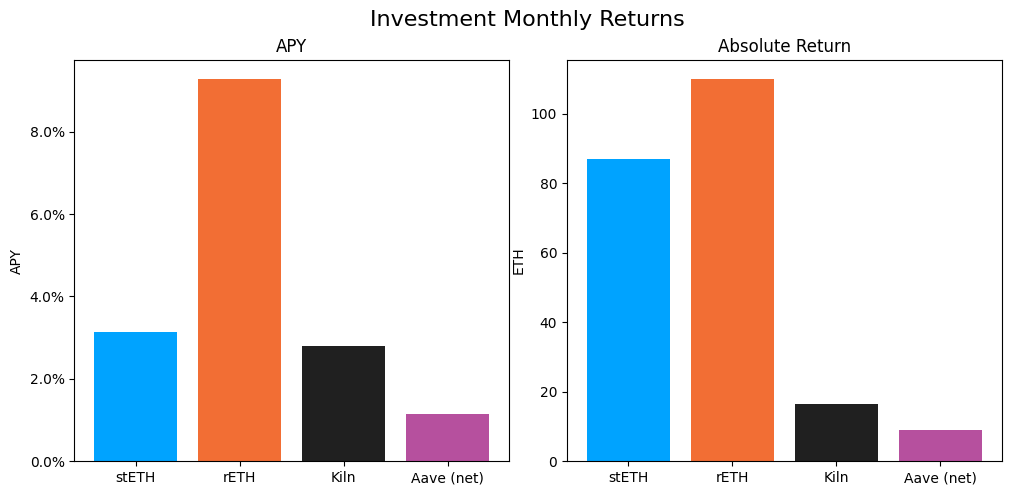

In [24]:
# MONTHLY RETURN GRAPHS FOR INDIVIDUAL INVESTMENTS

labels = ['stETH', 'rETH', 'Kiln', 'Aave (net)']
colors = ['#00a3ff', '#f26e34', '#202020', '#b6509e']

# Destructuring initialization
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle(f'Investment Monthly Returns', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

# Subplot
axs[0].bar(labels, [stETH_monthly_APY, rETH_monthly_APY, Kiln_monthly_APY_after_fees, aave_net_monthly_APY], color=colors)
axs[0].set_title('APY')
axs[0].set_ylabel('APY')
tick_vals = axs[0].get_yticks()
axs[0].set_yticklabels(['{:,.1%}'.format(x) for x in tick_vals])

# Subplot
axs[1].bar(labels, [stETH_monthly_return, rETH_monthly_return, Kiln_monthly_return*(1-0.0015), aave_net_monthly_return], color=colors);
axs[1].set_title('Absolute Return')
axs[1].set_ylabel('ETH')

plt.show();

In [25]:
# Total Monthly APY on the Capital Pool

# Total ETH earned
total_monthly_inv_earnings = round(stETH_monthly_return + rETH_monthly_return + Kiln_monthly_return + aave_net_monthly_return, 3)

# averaging the total ETH value of capital pool over the monthly period
total_cap_monthly_opening = df_cap.loc[df_cap['day'] == eom_before_valn_date]['sum'].values[0]
total_cap_monthly_closing = df_cap.loc[df_cap['day'] == valn_date]['sum'].values[0]
avg_total_cap_pool = (total_cap_monthly_closing + total_cap_monthly_opening) / 2

# monthly apy based on total earning
total_monthly_percentage = total_monthly_inv_earnings / avg_total_cap_pool
total_monthly_APY = ((1 + total_monthly_percentage) ** 12 - 1)

print(f'Total Monthly APY: {round(total_monthly_APY * 100, 3)}%')
print('Based on average Capital Pool amount over the monthly period')
print(f'Total ETH Earned: {total_monthly_inv_earnings}')

Total Monthly APY: 3.204%
Based on average Capital Pool amount over the monthly period
Total ETH Earned: 222.345


In [26]:
# Printout

print(f'stETH Monthly Return: {round(stETH_monthly_return, 3)}')
print(f'stETH Monthly APY: {round(stETH_monthly_APY * 100, 3)}%\n')
print(f'rETH Monthly Return: {round(rETH_monthly_return, 3)}')
print(f'rETH Monthly APY: {round(rETH_monthly_APY * 100, 3)}%\n')
print(f'Kiln Monthly Return: {round(Kiln_monthly_return, 3)}')
print(f'Enzyme Monthly APY: {round(Enzyme_monthly_APY_after_fees * 100, 3)}%; Kiln Portion Monthly APY: {round(Kiln_monthly_APY_after_fees * 100, 3)}%\n')
print(f'aEthWETH Return: {round(aEthWETH_monthly_return, 3)}')
print(f'aEthWETH APY: {round(aEthWETH_monthly_APY * 100, 3)}%')
print(f'debtUSDC Return: {round(debtUSDC_monthly_return, 3)}')
print(f'debtUSDC APY: {round(debtUSDC_monthly_APY * 100, 3)}%')
print(f'Aave Net Return: {round(aave_net_monthly_return, 3)}')
print(f'Aave Net APY: {round(aave_net_monthly_APY * 100, 3)}%\n')
print(f'Total ETH Earned: {total_monthly_inv_earnings}')
print(f'Total Monthly APY: {round(total_monthly_APY * 100, 3)}%')
print('Based on average Capital Pool amount over the monthly period\n')

print ('All returns after fees')

stETH Monthly Return: 86.916
stETH Monthly APY: 3.138%

rETH Monthly Return: 110.036
rETH Monthly APY: 9.276%

Kiln Monthly Return: 16.491
Enzyme Monthly APY: 1.337%; Kiln Portion Monthly APY: 2.79%

aEthWETH Return: 16.829
aEthWETH APY: 2.179%
debtUSDC Return: -7.928
debtUSDC APY: 5.349%
Aave Net Return: 8.901
Aave Net APY: 1.147%

Total ETH Earned: 222.345
Total Monthly APY: 3.204%
Based on average Capital Pool amount over the monthly period

All returns after fees


## Monthly Changes in Capital Pool 

/tmp/ipykernel_691/583210698.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  waterfall_plot.set_yticklabels(['{:,.0f}'.format(x) for x in tick_vals])
/tmp/ipykernel_691/583210698.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop] + row['amount']
/home/rei/.pyenv/versions/3.10.6/envs/investment_monitoring/lib/python3.10/site-packages/matplotlib/text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/home/rei/.pyenv/versions/3.10.6/envs/investment_monitoring/lib/python3.10/site-packages/matplotlib/text.py:754: FutureWarning: Calling float on a single element S

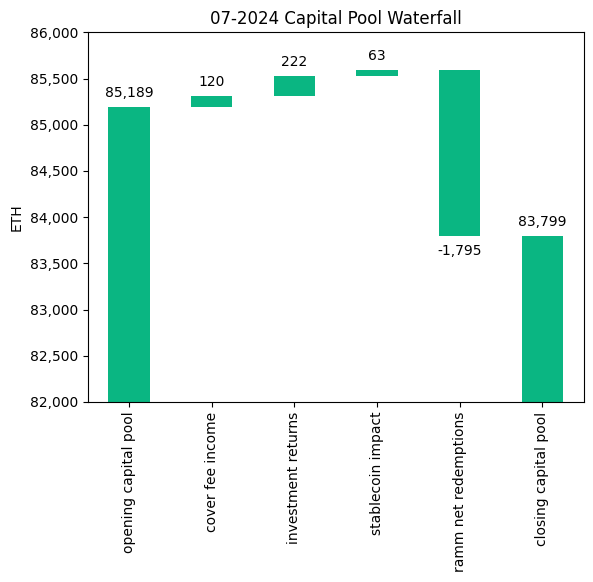

In [27]:
# waterfall chart for changes in the capital pool

# UPDATE
# set limits on chart manually
bottom = 82_000
top = 86_000

# create dataframe with relevant categories
index = ['opening capital pool', 'cover fee income', 'investment returns', 'stablecoin impact', 'ramm net redemptions']
data = {'amount': [total_cap_monthly_opening, monthly_cover_fees, total_monthly_inv_earnings, fx_change, ramm_flow_monthly_change]}
df_waterfall = pd.DataFrame(data=data, index=index)

# create a shifted dataframe by one space and fill the empty space with zero
df_shift = df_waterfall.amount.cumsum().shift(1).fillna(0)

# add the 'closing' line to both dataframes
total = df_waterfall.sum().amount
df_waterfall.loc['closing capital pool'] = total
df_shift.loc['closing capital pool'] = 0

# define the Nexus Mutual green color
color = '#0AB682'

# create waterfall plot
waterfall_plot = df_waterfall.plot.bar(stacked=True, bottom=df_shift,
                                   legend=None, color=color, title=f'{valn_date_str[-7:]} Capital Pool Waterfall')
waterfall_plot.set_ylim(bottom=bottom, top=top)
waterfall_plot.set_ylabel('ETH')

# change format of tick values
tick_vals = waterfall_plot.get_yticks()
waterfall_plot.set_yticklabels(['{:,.0f}'.format(x) for x in tick_vals])

# label loop for individual items
maximum = df_waterfall.max()
neg_offset = maximum / 400
pos_offset = maximum / 800

y_height = df_shift

loop = 0
for index, row in df_waterfall.iterrows():
    y = y_height[loop] + row['amount']
    # determine negative or positive offset
    if row['amount'] > 0:
        y += pos_offset
    else:
        y -= neg_offset
    waterfall_plot.annotate("{:,.0f}".format(row['amount']), (loop, y), ha="center")
    loop+=1

In [28]:
# Total change in capital pool
capital_pool_change = df_waterfall.loc['closing capital pool'].values[0] - df_waterfall.loc['opening capital pool'].values[0]
print(f'Capital Pool Total Change - {round(capital_pool_change, 2)}')
print(f'Capital Pool Percentage Change - {round(100 * capital_pool_change / (df_waterfall.loc["opening capital pool"].values[0]), 2)}%')

Capital Pool Total Change - -1390.19
Capital Pool Percentage Change - -1.63%


# Divestment Plan

## Pie Chart of Assets Today

In [29]:
today_row = df_cap.iloc[0]
today_row['Kiln'] = today_row['Enzyme'] - Enzyme_idle_portion
today_row['Enzyme Idle'] = Enzyme_idle_portion
today_row.rename({'Cover Re': 'Cover Re Investment', 'aEthWETH':'Cover Re Loan Collateral', 'variableDebtEthUSDC': 'Cover Re Loan Outstanding'}, inplace=True)
today_row

/tmp/ipykernel_691/1517165823.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  today_row['Kiln'] = today_row['Enzyme'] - Enzyme_idle_portion
/tmp/ipykernel_691/1517165823.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  today_row['Kiln'] = today_row['Enzyme'] - Enzyme_idle_portion
/tmp/ipykernel_691/1517165823.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  today_row['Enzyme Idle'] = Enzyme_idle_portion
/tmp/ipykernel_691/151

day                          2024-08-28 00:00:00
rate_ETH_USD                         2459.633676
ETH                                 11932.034443
DAI                                   250.012988
Enzyme                               13437.20479
stETH                               29481.631248
rETH                                14912.640009
USDC                                  191.676722
Cover Re Investment                  4881.237277
Cover Re Loan Collateral             9389.971047
Cover Re Loan Outstanding           -2329.209176
sum                                 82147.199347
Aave (net)                           7060.761871
Kiln                                  6861.53479
Enzyme Idle                              6575.67
Name: 0, dtype: object

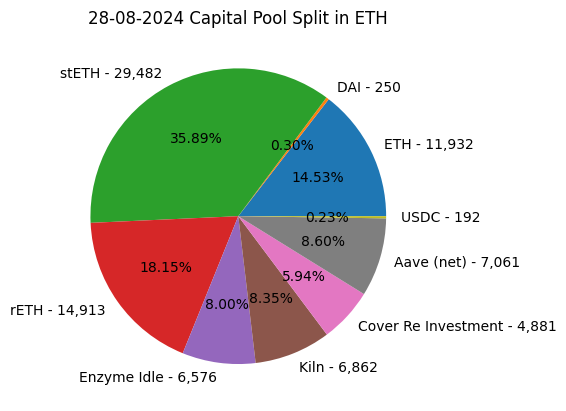

In [30]:
pie_asset_list = ['ETH', 'DAI', 'stETH', 'rETH', 'Enzyme Idle', 'Kiln', 'Cover Re Investment', 'Aave (net)', 'USDC']
today_row_pie = today_row[pie_asset_list]

# add formatted ETH values to labels
labels = []
for n, i in enumerate(pie_asset_list):
    formatted_value = '{:,.0f}'.format(today_row_pie.values[n])
    labels.append(f'{i} - {formatted_value}')

# create chart
# extract latest date in string format
today_date_str = df_cap.iloc[0]['day'].strftime('%d-%m-%Y')
# create chart
plt.pie(today_row_pie.values, labels=labels, autopct='%1.2f%%')
plt.title(f'{today_date_str} Capital Pool Split in ETH');

## Monthly Averages Since Start of 2024 

In [31]:
# get today's day, month and year

day_today = datetime.now().day
month_today = datetime.now().month
year_today = datetime.now().year

# get eth price today
eth_usd_today = df_cap.iloc[0]['rate_ETH_USD']

# manually input average start date
averages_start_date_str = '01-08-2023'
# create average start datetime
averages_start_date = datetime.strptime(averages_start_date_str, '%d-%m-%Y')

In [32]:
# loop through months since the start date and obtain averages

date = averages_start_date
ramm_flows = []
net_eth_fees = []
claim_ratio = 0.7
stETH_returns = []
rETH_returns = []

while date < datetime(year_today, month_today, 1):
    next_month = datetime(year = date.year + int(date.month / 12), month = (date.month % 12) + 1, day=date.day)
    
    # RAMM FLOWS
    # determine net ramm flows in month in 2024
    if date.year >= 2024:
        ramm_flows_opening = df_ramm.loc[df_ramm['ts'] == date]['cummulative_eth_in'].values[0] - df_ramm.loc[df_ramm['ts'] == date]['cummulative_eth_out'].values[0]
        ramm_flows_closing = df_ramm.loc[df_ramm['ts'] == next_month]['cummulative_eth_in'].values[0] - df_ramm.loc[df_ramm['ts'] == next_month]['cummulative_eth_out'].values[0]
        ramm_flows_change = ramm_flows_closing - ramm_flows_opening
        ramm_flows.append(ramm_flows_change)
    
    # COVERS
    # filter for covers that were bought in the relevant month
    df_cover_flows = df_covers[(df_covers['cover_start_time']>=date) & (df_covers['cover_start_time']<next_month)]

    # filter for covers that were paid for in ETH
    # (note covers paid in NXM don't generate assets and covers paid for in DAI/USDC will be used to pay off the Cover Re loan)
    df_cover_flows = df_cover_flows[df_cover_flows['premium_asset'] == 'ETH']

    # work out cover fees, allowing for 15% commission
    eth_cover_fees = df_cover_flows['premium_native'].sum() * 0.85
    # append to list, allowing for 70% claim ratio
    net_eth_monthly_fees = eth_cover_fees * (1 - claim_ratio)
    net_eth_fees.append(net_eth_monthly_fees)
    
    # INVESTMENT INCOME
    # stETH
    stETH_opening = df_cap.loc[df_cap['day'] == date]['stETH'].values[0]
    stETH_closing = df_cap.loc[df_cap['day'] == next_month]['stETH'].values[0]
    stETH_returns.append(stETH_closing - stETH_opening)
    # rETH
    rETH_opening = df_cap.loc[df_cap['day'] == date]['rETH'].values[0]
    rETH_closing = df_cap.loc[df_cap['day'] == next_month]['rETH'].values[0]
    rETH_returns.append(rETH_closing - rETH_opening) 
    
    # move date along
    date = next_month

# Average Kiln rewards in month
days_total_kiln_rewards = (df_cap.iloc[0]['day'] - kiln_deposit_date)/timedelta(days=1)
daily_total_kiln_rewards = kiln_total_rewards / days_total_kiln_rewards
avg_monthly_kiln_returns = daily_total_kiln_rewards * avg_days_in_month

# Average RAMM flows
avg_monthly_ramm_flows = sum(ramm_flows)/len(ramm_flows)

# Average ETH Cover Fees
avg_monthly_net_eth_fees = sum(net_eth_fees)/len(net_eth_fees)

# Average stETH returns
avg_monthly_stETH_returns = sum(stETH_returns)/len(stETH_returns)

# Average rETH returns
avg_monthly_rETH_returns = sum(rETH_returns)/len(rETH_returns)

print(f'Average monthly stETH returns = {avg_monthly_stETH_returns}')
print(f'Average monthly rETH returns = {avg_monthly_rETH_returns}')
print(f'Average monthly kiln returns = {avg_monthly_kiln_returns}')
print(f'Average monthly net ETH cover fees = {avg_monthly_net_eth_fees}')
print(f'Average monthly RAMM flows = {avg_monthly_ramm_flows}')

Average monthly stETH returns = 96.24901643286012
Average monthly rETH returns = 44.364462019339804
Average monthly kiln returns = 21.23788977043269
Average monthly net ETH cover fees = 4.410927262581494
Average monthly RAMM flows = -2707.3412885662224


## Asset Projection

In [33]:
today_row

day                          2024-08-28 00:00:00
rate_ETH_USD                         2459.633676
ETH                                 11932.034443
DAI                                   250.012988
Enzyme                               13437.20479
stETH                               29481.631248
rETH                                14912.640009
USDC                                  191.676722
Cover Re Investment                  4881.237277
Cover Re Loan Collateral             9389.971047
Cover Re Loan Outstanding           -2329.209176
sum                                 82147.199347
Aave (net)                           7060.761871
Kiln                                  6861.53479
Enzyme Idle                              6575.67
Name: 0, dtype: object

In [34]:
proj_asset_list = ['ETH', 'DAI', 'stETH', 'rETH', 'Enzyme Idle', 'Kiln', 'Cover Re Investment', 'Cover Re Loan Collateral',
                   'Cover Re Loan Outstanding', 'USDC']
today_row_proj = today_row[proj_asset_list]

asset_df = pd.DataFrame(today_row_proj).T

projection_months = 12
aave_eth_supply_apy = 0.0154
aave_usdc_borrow_apy = 0.0871
cover_re_apy = 0.2

for i in range(projection_months):
    
    next_row = {}
    next_row['ETH'] = asset_df['ETH'].values[-1] + avg_monthly_ramm_flows + avg_monthly_net_eth_fees
    next_row['DAI'] = asset_df['DAI'].values[-1]
    next_row['USDC'] = asset_df['USDC'].values[-1]
    next_row['stETH'] = asset_df['stETH'].values[-1] + avg_monthly_stETH_returns
    next_row['rETH'] = asset_df['rETH'].values[-1] + avg_monthly_rETH_returns
    next_row['Kiln'] = asset_df['Kiln'].values[-1] + avg_monthly_kiln_returns
    next_row['Enzyme Idle'] = asset_df['Enzyme Idle'].values[-1]
    next_row['Cover Re Investment'] = asset_df['Cover Re Investment'].values[-1] * ((1 + cover_re_apy)**(1/12))
    next_row['Cover Re Loan Collateral'] = asset_df['Cover Re Loan Collateral'].values[-1] * ((1 + aave_eth_supply_apy)**(1/12))
    next_row['Cover Re Loan Outstanding'] = asset_df['Cover Re Loan Outstanding'].values[-1] * ((1 + aave_usdc_borrow_apy)**(1/12))
    
    asset_df.loc[len(asset_df)] = next_row

asset_df

,ETH,DAI,stETH,rETH,Enzyme Idle,Kiln,Cover Re Investment,Cover Re Loan Collateral,Cover Re Loan Outstanding,USDC
0,11932.034443,250.012988,29481.631248,14912.640009,6575.67,6861.53479,4881.237277,9389.971047,-2329.209176,191.676722
1,9229.104082,250.012988,29577.880265,14957.004471,6575.67,6882.77268,4955.966435,9401.937282,-2345.475768,191.676722
2,6526.17372,250.012988,29674.129281,15001.368933,6575.67,6904.010569,5031.839657,9413.918765,-2361.855961,191.676722
3,3823.243359,250.012988,29770.378298,15045.733395,6575.67,6925.248459,5108.874457,9425.915518,-2378.350549,191.676722
4,1120.312998,250.012988,29866.627314,15090.097857,6575.67,6946.486349,5187.08862,9437.927558,-2394.960331,191.676722
5,-1582.617364,250.012988,29962.87633,15134.462319,6575.67,6967.724239,5266.5002,9449.954906,-2411.686111,191.676722
6,-4285.547725,250.012988,30059.125347,15178.826781,6575.67,6988.962128,5347.12753,9461.997582,-2428.5287,191.676722
7,-6988.478086,250.012988,30155.374363,15223.191243,6575.67,7010.200018,5428.989221,9474.055604,-2445.488913,191.676722
8,-9691.408447,250.012988,30251.62338,15267.555705,6575.67,7031.437908,5512.104171,9486.128993,-2462.567572,191.676722
9,-12394.338809,250.012988,30347.872396,15311.920167,6575.67,7052.675798,5596.491567,9498.217767,-2479.765504,191.676722


In [35]:
asset_df_6_mo = asset_df[:6].astype(float)
asset_df_6_mo_pos = asset_df_6_mo.drop(columns=['Cover Re Loan Outstanding'])

/tmp/ipykernel_691/1641516350.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  projection_plot.set_yticklabels(['{:,.0f}'.format(x) for x in tick_vals]);


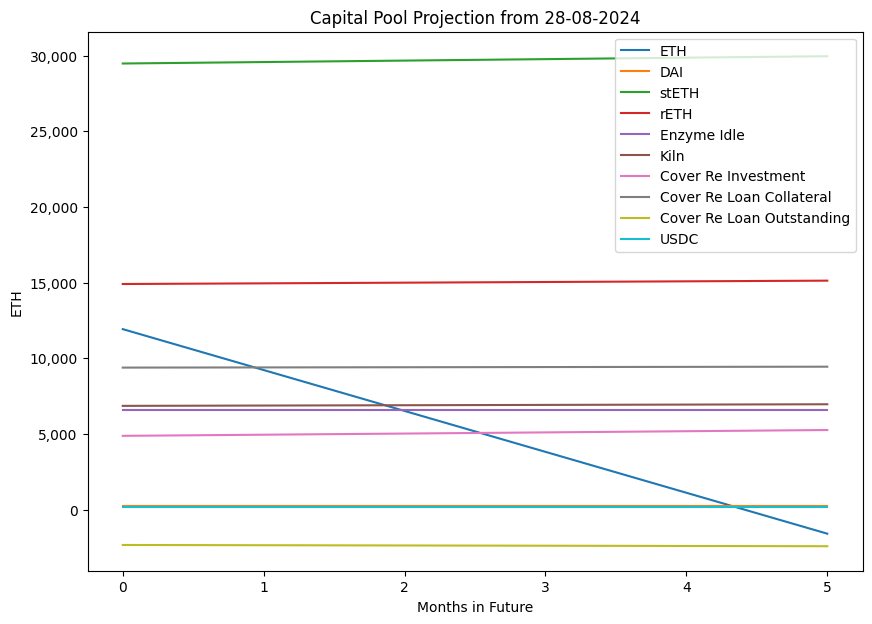

In [36]:
projection_plot = asset_df_6_mo.plot(title=f'Capital Pool Projection from {today_date_str}',
                                    figsize=(10, 7), legend=True, ylabel='ETH', xlabel='Months in Future')

tick_vals = projection_plot.get_yticks()
projection_plot.set_yticklabels(['{:,.0f}'.format(x) for x in tick_vals]);

/tmp/ipykernel_691/1806150064.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  projection_bar_plot.set_yticklabels(['{:,.0f}'.format(x) for x in tick_vals]);


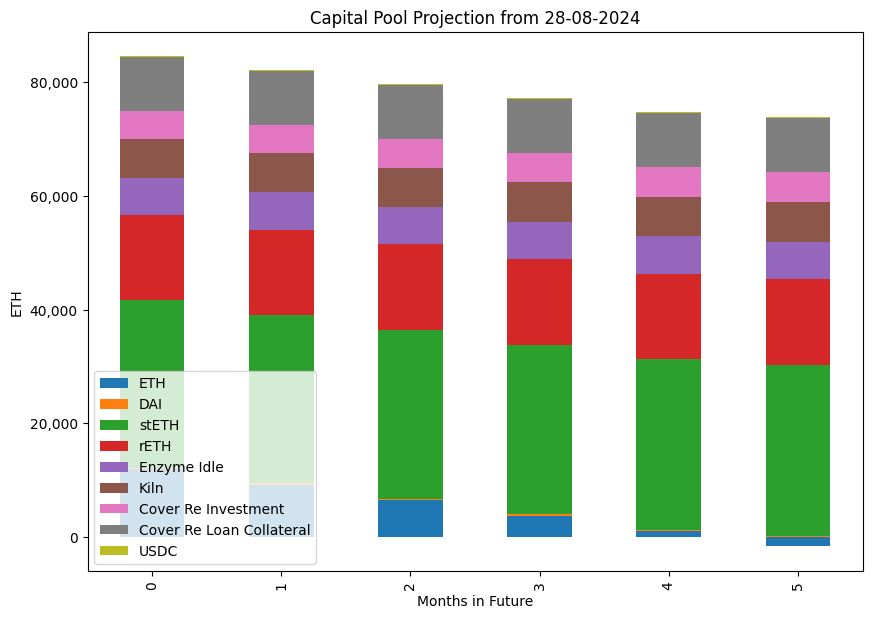

In [37]:
projection_bar_plot = asset_df_6_mo_pos.plot(kind='bar', stacked=True, title=f'Capital Pool Projection from {today_date_str}',
                                    figsize=(10, 7), legend=True, ylabel='ETH', xlabel='Months in Future')

tick_vals = projection_bar_plot.get_yticks()
projection_bar_plot.set_yticklabels(['{:,.0f}'.format(x) for x in tick_vals]);

In [38]:
df_sum = asset_df_6_mo_pos.sum(axis=1)
df_rel = asset_df_6_mo_pos.div(df_sum, 0)*100
df_rel

,ETH,DAI,stETH,rETH,Enzyme Idle,Kiln,Cover Re Investment,Cover Re Loan Collateral,USDC
0,14.124694,0.295956,34.899248,17.653023,7.784031,8.122427,5.778225,11.115495,0.226900
1,11.251983,0.304812,36.060900,18.235351,8.016956,8.391371,6.042239,11.462698,0.233689
2,8.201925,0.314210,37.293674,18.853330,8.264131,8.676781,6.323885,11.831168,0.240894
3,4.957734,0.324201,38.604294,19.510330,8.526902,8.980213,6.624857,12.222915,0.248554
4,1.500435,0.334842,40.000358,20.210160,8.806791,9.303425,6.947065,12.640211,0.256713
5,-2.191497,0.346200,41.490485,20.957139,9.105525,9.648415,7.292679,13.085633,0.265420


In [39]:
for n in df_rel: 
    for i, (cs, ab, pc) in enumerate(zip(asset_df_6_mo_pos.cumsum(1)[n],  
                                         asset_df_6_mo_pos[n], df_rel[n])): 
        print(cs - ab / 2, i, str(np.round(pc, 1)) + '%')

5966.017221486287 0 14.1%
4614.552040834466 1 11.3%
3263.0868601826464 2 8.2%
1911.621679530826 3 5.0%
560.1564988790055 4 1.5%
-791.3086817728149 5 -2.2%
12057.040936965837 0 0.3%
9354.110575662196 1 0.3%
6651.180214358556 2 0.3%
3948.249853054916 3 0.3%
1245.3194917512749 4 0.3%
-1457.610869552366 5 0.3%
26922.863055089794 0 34.9%
24268.05720200258 1 36.1%
21613.251348915375 2 37.3%
18958.445495828164 3 38.6%
16303.639642740949 4 40.0%
13648.83378965374 5 41.5%
49119.99868362112 0 17.7%
46535.49956976 1 18.2%
43951.0004558989 2 18.9%
41366.50134203779 3 19.5%
38782.00222817667 4 20.2%
36197.503114315565 5 21.0%
59864.15368802175 0 7.8%
57301.83680517031 1 8.0%
54739.519922318876 2 8.3%
52177.20303946743 3 8.5%
49614.88615661598 4 8.8%
47052.569273764544 5 9.1%
66582.7560829342 0 8.1%
64031.05814496797 1 8.4%
61479.36020700175 2 8.7%
58927.66226903552 3 9.0%
56375.96433106929 4 9.3%
53824.26639310307 5 9.6%
72454.14211611946 0 5.8%
69950.42770208219 1 6.0%
67447.28531996552 2 6.3%
649

/tmp/ipykernel_691/4137318079.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  projection_bar_perc_plot.set_yticklabels(['{:,.0f}'.format(x) for x in tick_vals])


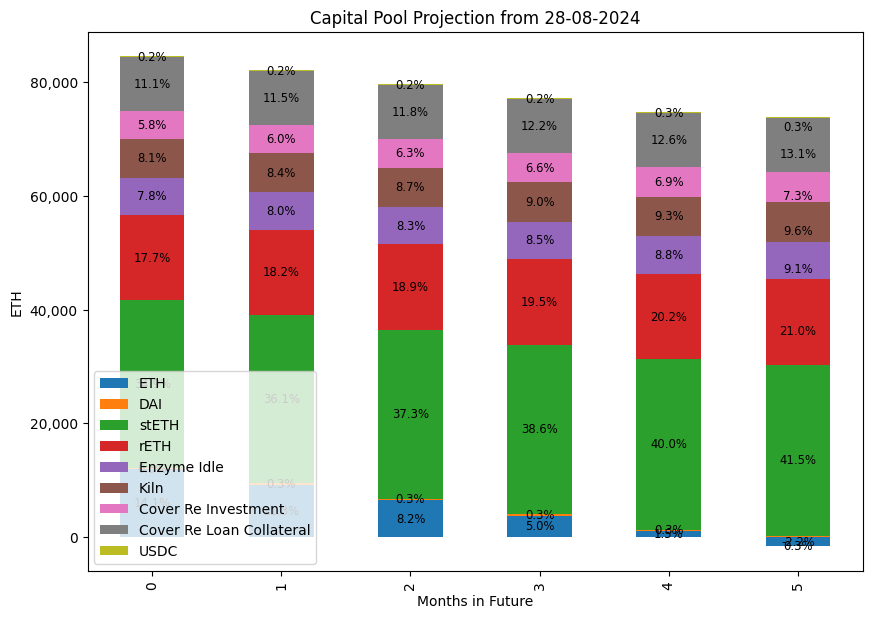

In [40]:
projection_bar_perc_plot = asset_df_6_mo_pos.plot(kind='bar', stacked=True, title=f'Capital Pool Projection from {today_date_str}',
                                    figsize=(10, 7), legend=True, ylabel='ETH', xlabel='Months in Future')

tick_vals = projection_bar_perc_plot.get_yticks()
projection_bar_perc_plot.set_yticklabels(['{:,.0f}'.format(x) for x in tick_vals])

for n in df_rel: 
     for i, (cs, ab, pc) in enumerate(zip(asset_df_6_mo_pos.cumsum(1)[n],  
                                         asset_df_6_mo_pos[n], df_rel[n])): 
         projection_bar_perc_plot.text(y= cs - ab / 2, x=i, s=str(np.round(pc, 1)) + '%',
                             va = 'center', ha = 'center', size = 'small')